# Welcome to the 210Pb age model script v2.2!

### <div style="text-align: right"> Last modified by A.A. Lehrmann 4 September 2025 </div>


### The script below will extract radioisotope data from Canberra PDFs, run the age model (from the Wellner Lab Group excel model (Appleby, 2001; Boldt et al., 2013), and plot the age model

### Important instructions before you begin:

    1. NEVER edit raw data. Do not delete Canberra PDFs. Do not remove sediment weights from original lab notebook excel sheet.

    2. Make an /CORE_AgeModelOutput/ folder to put all of your script's outputs

    3. When copying folder paths, make sure to remove quotation marks


## First, extract radioisotope data from Canberra PDFs
Run cell (press triangle that says run) and follow instructions.

In [1]:
#import required libraries
import os
import pandas as pd
from PyPDF2 import PdfReader
from pathlib import Path
from datetime import datetime
import re

In [14]:
# --- Helper: prefer highest version (_v2, _v3, …) for BOTH Canberra and PtSrc files ---
import os, re, numpy as np, pandas as pd

# Capture depth AND optional version (e.g., 21-24, 21-24cm, 21-24_v2, 21-24cm_v3, etc.)
DEPTH_RE = re.compile(r'(\d{1,3}-\d{1,3})(?:cm)?(?:_v(\d+))?(?=\.|_|$)', re.IGNORECASE)

def _depth_and_version(s: str):
    base = os.path.basename(str(s))
    m = DEPTH_RE.search(base)
    if not m:
        return None, 0
    depth = m.group(1)                 # standardized like "21-24"
    version = int(m.group(2)) if m.group(2) else 0
    return depth, version

def reshape_canberra_with_ptsrc_mixed(df_in: pd.DataFrame,
                                      write_to: str | None = None,
                                      ptsrc_cols: tuple[str,str] = ("Pb-210", "Pb-210 error")) -> pd.DataFrame:
    """
    Works on a single mixed table (Canberra + PtSrc rows).
    - For any duplicate depths on either side, keeps the **highest _vN**.
    - Adds H/I/J = ['ptsrc_pb210','ptsrc_pb210 error','file ptsrc'] right after 'Pb-214 error'.
    - Preserves your original header names (no renaming of 'error' columns).
    """
    if "File" not in df_in.columns:
        raise KeyError("Input dataframe must contain a 'File' column.")

    df = df_in.copy()

    # Split rows by prefix
    is_ptsrc = df["File"].astype(str).str.startswith("PtSrc_")
    can_df = df.loc[~is_ptsrc].copy()
    pt_df  = df.loc[ is_ptsrc].copy()

    # Extract (depth, version) for both sides
    can_df[["__depth__","__ver__"]] = can_df["File"].apply(lambda s: pd.Series(_depth_and_version(s)))
    pt_df[["__depth__","__ver__"]]  = pt_df["File"].apply(lambda s: pd.Series(_depth_and_version(s)))

    # **Prefer highest version for Canberra** when duplicates share the same depth
    can_df = can_df.sort_values("__ver__").drop_duplicates(subset="__depth__", keep="last")

    # Pick value/error columns in PtSrc rows
    val_col, err_col = ptsrc_cols
    if val_col not in pt_df.columns or err_col not in pt_df.columns:
        # Fallback: first two numeric columns
        num_cols = [c for c in pt_df.columns if c != "File" and np.issubdtype(pt_df[c].dtype, np.number)]
        if len(num_cols) < 2:
            for c in pt_df.columns:
                if c != "File":
                    pt_df[c] = pd.to_numeric(pt_df[c], errors="coerce")
            num_cols = [c for c in pt_df.columns if c != "File" and np.issubdtype(pt_df[c].dtype, np.number)]
        val_col, err_col = num_cols[:2]

    # Reduce PtSrc to needed columns and **prefer highest version per depth**
    q = pt_df.loc[:, ["__depth__", "__ver__", "File", val_col, err_col]].copy()
    q.rename(columns={
        "File": "file ptsrc",
        val_col: "ptsrc_pb210",
        err_col: "ptsrc_pb210 error"
    }, inplace=True)
    q["file ptsrc"] = q["file ptsrc"].map(lambda x: os.path.basename(str(x)))
    q = q.sort_values("__ver__").drop_duplicates(subset="__depth__", keep="last")

    # Merge and clean
    out = can_df.merge(q.drop(columns="__ver__"), on="__depth__", how="left")
    out.drop(columns=["__depth__","__ver__"], errors="ignore", inplace=True)

    # Desired column order (keep original header names)
    base = ["File","Pb-210","Pb-210 error","Bi-214","Bi-214 error","Pb-214","Pb-214 error"]
    hij  = ["ptsrc_pb210","ptsrc_pb210 error","file ptsrc"]
    others = [col for col in out.columns if col not in base + hij]
    out = out[[c for c in base if c in out.columns] + hij + others]

    if write_to:
        out.to_csv(write_to, index=False)
    return out


In [3]:
#add age model information
SCRIPT_VERSION = "v2.2"
OPERATOR_NAME = input("Operator name: ").strip()
_default = datetime.today().strftime("%Y%m%d")
_run = input(f"Run date [YYYYMMDD] (Enter for { _default }): ").strip() or _default
RUN_DATE = _run
CORE_NAME_RAW = input("Core name (e.g., MB1901): ").strip()

Operator name:  AALehrmann
Run date [YYYYMMDD] (Enter for 20250904):  
Core name (e.g., MB1901):  NBP2002 KC72


In [4]:
#session metadata
CORE_NAME = re.sub(r"[^A-Za-z0-9]+", "", CORE_NAME_RAW)
SUFFIX = f"_{CORE_NAME}_{RUN_DATE}"
META = {"operator": OPERATOR_NAME, "date": RUN_DATE, "core": CORE_NAME, "version": SCRIPT_VERSION, "suffix": SUFFIX}

def compose_output_name(basename: str, ext: str, directory: Path | str = Path.cwd()) -> Path:
    """
    Returns a full Path like <directory>/<basename>_<CoreName_YYYYMMDD><ext>
    """
    directory = Path(directory)
    base = f"{basename}{META['suffix']}"
    if not ext.startswith("."):
        ext = "." + ext
    return directory / f"{base}{ext}"

In [5]:
#write readme files
def write_readme(for_path: Path):
    """
    Creates: <basename>_README_<YYYYMMDD>.txt next to the file.
    Prompts for optional notes.
    """
    notes = input(f"Notes for {for_path.name} (optional): ").strip()
    base_no_ext = for_path.with_suffix("").name
    readme_name = f"{base_no_ext}_README_{META['date']}.txt"
    readme_path = for_path.parent / readme_name
    content = [
        f"Output file: {for_path.name}",
        f"Operator: {META['operator']}",
        f"Run date (YYYYMMDD): {META['date']}",
        f"Script version: {META['version']}",
        f"Core name: {META['core']}",
        f"Notes: {notes if notes else '(none)'}",
        ""
    ]
    readme_path.write_text("\n".join(content), encoding="utf-8")
    print(f"README created -> {readme_path}")

In [6]:
#Process pt_src files
def process_ptsrc_pdf(file_path, filename):
    try:
        reader = PdfReader(file_path)
        if len(reader.pages) < 3:
            print(f"PDF file '{filename}' has less than 3 pages. Skipping.")
            return None
        page = reader.pages[2]
        text = page.extract_text()
        lines = text.split('\n')
        for line in lines:
            if 'Pb-210' in line:
                ptsrc_pb210, PtSrc_Pb210error = line.split()[-2:]
                return {
                    'File': filename,
                    'Pb-210': float(ptsrc_pb210),
                    'Pb-210 error': float(PtSrc_Pb210error)
                }
        print(f"Pb-210 not found in '{filename}'. Skipping.")
        return None
    except Exception as e:
        print(f"Error processing PDF file '{filename}': {e}")
        return None


In [7]:
#Process regular files
def process_regular_pdf(file_path, filename):
    pb210 = pb210error = Bi214 = Bi214error = Pb214 = Pb214error = None
    try:
        reader = PdfReader(file_path)
        if len(reader.pages) < 3:
            print(f"PDF file '{filename}' has less than 3 pages. Skipping.")
            return None
        page = reader.pages[2]
        text = page.extract_text()
        lines = text.split('\n')
        for line in lines:
            if 'Pb-210' in line:
                pb210, pb210error = line.split()[-2:]
            elif 'Bi-214' in line:
                Bi214, Bi214error = line.split()[-2:]
            elif 'Pb-214' in line:
                Pb214, Pb214error = line.split()[-2:]
        if pb210 is None or pb210error is None:
            print(f"Pb-210 not found in '{filename}'. Skipping.")
            return None
        if Bi214 is None or Bi214error is None:
            print(f"Bi-214 not found in '{filename}'. Skipping.")
            return None
        if Pb214 is None or Pb214error is None:
            print(f"Pb-214 not found in '{filename}'. Skipping.")
            return None
        return {
            'File': filename,
            'Pb-210': float(pb210),
            'Pb-210 error': float(pb210error),
            'Bi-214': float(Bi214),
            'Bi-214 error': float(Bi214error),
            'Pb-214': float(Pb214),
            'Pb-214 error': float(Pb214error)
        }
    except Exception as e:
        print(f"Error processing PDF file '{filename}': {e}")
        return None

In [8]:
#define PDF processing
def process_pdf_file(file_path, filename):
    if filename.startswith("PtSrc_"):
        return process_ptsrc_pdf(file_path, filename)
    else:
        return process_regular_pdf(file_path, filename)

In [9]:
#Extract PDF data from folder
def extract_pdf_data(folder_path):
    combined_data = []
    for filename in os.listdir(folder_path):
        # Check for PDF extension (case-insensitive)
        if filename.lower().endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            data = process_pdf_file(file_path, filename)
            if data is not None:
                combined_data.append(data)
    return combined_data

In [10]:
#Sort and process PDFs
def sort_pdf_data(combined_data, parse_numbers=False):
    combined_df = pd.DataFrame(combined_data)
    
    def extract_numeric_suffix(file_name):
        try:
            parts = file_name.split('_')[-1].split('.')[0]
            return int(parts)
        except ValueError:
            return float('nan')
    
    combined_df['File_order'] = combined_df['File'].apply(extract_numeric_suffix)
    combined_df = combined_df.sort_values(by='File_order').drop(columns=['File_order'])
    
    if parse_numbers:
        for col in ['Pb-210', 'Bi-214', 'Pb-214']:
            if col in combined_df.columns:
                combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    return combined_df

In [15]:
# Export to csv
def extract_pdf_values(folder_path, output_csv_path, parse_numbers=False):
    combined_data = extract_pdf_data(folder_path)
    combined_df = sort_pdf_data(combined_data, parse_numbers)

    # Use the helper to match by depth and insert H/I/J (ptsrc, ptsrc_error, file ptsrc)
    final_df = reshape_canberra_with_ptsrc_mixed(combined_df, write_to=output_csv_path)

    csv_path = Path(output_csv_path)
    print(f"CSV saved -> {csv_path}")
    write_readme(csv_path)

In [16]:
# User inputs
folder_path = input("Enter the folder path of Canberra PDFs: ").strip()

# Auto-generate CSV output name based on metadata
output_csv_path = compose_output_name("CanberraData", ".csv", Path(folder_path))
print(f"CSV will be saved as -> {output_csv_path}")


Enter the folder path of Canberra PDFs:  D:\210Pb_thismachine\NBP2002_KC72_gamma spec data


CSV will be saved as -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\CanberraData_NBP2002KC72_20250904.csv


In [17]:
#Execute functions
extract_pdf_values(folder_path, output_csv_path)

CSV saved -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\CanberraData_NBP2002KC72_20250904.csv


Notes for CanberraData_NBP2002KC72_20250904.csv (optional):  Samples run by Jamie Jetton


README created -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\CanberraData_NBP2002KC72_20250904_README_20250904.txt


### Make note of which samples are missing data! This will be important when we plot!

# Create a new .csv file from lab notebook for the sample weight data

Sample weights should have the following headings: 

### | Core    | Top of interval (cm)   | Center point of interval    |Base of interval (cm)  | sediment weight (g)    | 




Run cell below

In [18]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# Prompt user for file paths
csv1_path = input("Enter the path to the sample weight CSV file (e.g., /path/weights.csv): ").strip()
csv2_path = input("Enter the path to the Canberra data CSV file (e.g., /path/canberra.csv): ").strip()

# Use Canberra CSV's folder as output directory
out_dir = Path(csv2_path).parent

# Auto-generate Age Model output name
output_file_name = compose_output_name("AgeModel", ".csv", out_dir)
print(f"Output file will be saved as -> {output_file_name}")


Enter the path to the sample weight CSV file (e.g., /path/weights.csv):  D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\output\NBP202KC72_weights-allnewdish.csv
Enter the path to the Canberra data CSV file (e.g., /path/canberra.csv):  D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\CanberraData_NBP2002KC72_20250904.csv


Output file will be saved as -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModel_NBP2002KC72_20250904.csv


In [19]:
#Load and merge data
# Load the CSV files
csv1 = pd.read_csv(csv1_path)
csv2 = pd.read_csv(csv2_path)

# Extract 'Center point of interval' from csv2 based on the median of the last digits in 'File'
csv2['Center point of interval'] = csv2['File'].apply(
    lambda x: np.median([int(num) for num in re.findall(r'\d+', x.split('_')[-1])])
)

# Merge CSV files on 'Center point of interval'
data = pd.merge(csv1, csv2, on='Center point of interval', how='left')

In [20]:
# Prompt the user for the year of core
year_of_core = int(input("Enter the year of core (e.g., 2023): "))

Enter the year of core (e.g., 2023):  2020


In [21]:
# Calculate activity and correction factors
data['Pb-210 activity Uncertainty (Bq-g)'] = data['Pb-210 error']/data['sediment weight (g)']
data['Pb-210 activity (Bq/g)'] = data['Pb-210'] / data['sediment weight (g)']
data['Pb-210 correction factor'] = data['ptsrc_pb210'] / 151031.56
data['Self absorb. Corrected Pb-210 activity (Bq/g)'] = (
    data['Pb-210 activity (Bq/g)'] / data['Pb-210 correction factor']
)
data['Bi-214 activity (Bq/g)'] = data['Bi-214'] / data['sediment weight (g)']
data['Pb-214 activity (Bq/g)'] = data['Pb-214'] / data['sediment weight (g)']

In [22]:
# Calculate averaged supported activity of Bi-214 and Pb-214 (Bq/g)
data['Averaged supported activity of Bi-214 and Pb-214 (Bq/g)'] = (
    data['Bi-214 activity (Bq/g)'] + data['Pb-214 activity (Bq/g)']
) / 2

# Calculate background activity uncertainty (Bq/g)
data['Background activity uncertainty (Bq/g)'] = (
    (data['Bi-214 error'] + data['Pb-214 error']) / 2
) / data['sediment weight (g)']

In [23]:
# Calculate Excess Pb-210 (Bq/g)
data['Excess Pb-210 (Bq/g)'] = (
    data['Self absorb. Corrected Pb-210 activity (Bq/g)'] -
    data['Averaged supported activity of Bi-214 and Pb-214 (Bq/g)']
)

# Determine surface activity (first interval value)
data['Surface activity'] = data['Excess Pb-210 (Bq/g)'].iloc[0]

# Calculate Age bp using the natural logarithm
data['Age bp'] = (1 / 0.03114) * np.log(data['Surface activity'] / data['Excess Pb-210 (Bq/g)'])


In [24]:
def save_dataframe(df, basename: str, directory=Path.cwd(), index=False):
    """
    Saves a pandas DataFrame as CSV with _CoreNameYYYYMMDD suffix and README.
    """
    out_path = compose_output_name(basename, ".csv", directory)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=index)

    print(f"CSV saved -> {out_path}")
    write_readme(out_path)

In [25]:
from pathlib import Path

def _resolve_csv_target(output_csv_path, default_basename="pdf_extraction"):
    """
    Accepts either a directory or a file path. 
    - If a directory or a path without extension is provided, creates it if needed and
      returns <directory>/<default_basename>_CoreNameYYYYMMDD.csv using compose_output_name().
    - If a .csv file path is provided, returns it as-is (and ensures parent exists).
    """
    p = Path(output_csv_path)

    # Explicit .csv file path
    if p.suffix.lower() == ".csv":
        p.parent.mkdir(parents=True, exist_ok=True)
        return p

    # Treat as a directory (existing or to be created)
    if p.exists() and p.is_dir():
        return compose_output_name(default_basename, ".csv", p)

    if p.suffix == "":
        # looks like a folder path without extension; make it a directory
        p.mkdir(parents=True, exist_ok=True)
        return compose_output_name(default_basename, ".csv", p)

    # Fallback: force .csv extension
    p = p.with_suffix(".csv")
    p.parent.mkdir(parents=True, exist_ok=True)
    return p


In [26]:
def save_text(text: str, basename: str, directory=Path.cwd(), ext=".txt"):
    """
    Saves a string as text with _CoreNameYYYYMMDD suffix and README.
    """
    out_path = compose_output_name(basename, ext, directory)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    Path(out_path).write_text(text, encoding="utf-8")

    print(f"Text saved -> {out_path}")
    write_readme(out_path)

In [27]:
# Calculate 'calendar years pre year of core'
data['calendar years pre year of core'] = year_of_core - data['Age bp']

from pathlib import Path
out_dir = Path(output_file_name).parent if output_file_name else Path.cwd()
save_dataframe(data, basename="AgeModel", directory=out_dir, index=False)

CSV saved -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModel_NBP2002KC72_20250904.csv


Notes for AgeModel_NBP2002KC72_20250904.csv (optional):  Samples run by Jamie Jetton


README created -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModel_NBP2002KC72_20250904_README_20250904.txt


# Check the output data. Make sure data isnt *fishy*
Look at the column labeled 'Age'. Are the ages within the realm of possibility? If not, ask Asmara for help!

# Now plot it!
Run cell below 

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

# Ask for the age model file to be plotted (CSV format)
age_model_file = input("Enter the full path to the age model file to plot (e.g., /path/to/age_model.csv): ")
data = pd.read_csv(age_model_file)


Enter the full path to the age model file to plot (e.g., /path/to/age_model.csv):  D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModel_NBP2002KC72_20250904.csv


In [29]:
# Get the core name for the plot title
core_name = input("Enter the core name for the title: ")

# Ask for depths to label "calendar years pre year of core"
depths_to_label_input = input("Enter the depths (comma-separated) where 'calendar years pre year of core' should be labeled (or type 'all' to label all intervals): ")

if depths_to_label_input.lower() == 'all':
    depths_to_label = data['Center point of interval'].tolist()  # Label all intervals
else:
    depths_to_label = [float(depth.strip()) for depth in depths_to_label_input.split(",")]

Enter the core name for the title:  NBP2002 KC72
Enter the depths (comma-separated) where 'calendar years pre year of core' should be labeled (or type 'all' to label all intervals):  all


In [30]:
# Ask if any intervals have undetectable radioisotope amounts
missing_data_input = input("Are there any intervals with undetectable amounts of radioisotopes? (yes/no): ").strip().lower()

if missing_data_input == 'yes':
    missing_depths_input = input("Enter the depths (comma-separated) with undetectable radioisotopes: ")
    missing_depths = [float(depth.strip()) for depth in missing_depths_input.split(",")]
else:
    missing_depths = []


Are there any intervals with undetectable amounts of radioisotopes? (yes/no):  no


In [31]:
# Define colors for the data series and error bars
excess_pb210_color = 'black'
excess_pb210_error_color = mcolors.to_rgba(excess_pb210_color, alpha=0.3)
supported_activity_color = 'grey'
supported_activity_error_color = mcolors.to_rgba(supported_activity_color, alpha=0.3)

# Ask for the folder to save the plot PDF and create a filename
save_location = input("Enter the full path where you want to save the plot PDF (e.g., /path/to/your/directory): ")
plot_filename = f"{core_name}_Age_Model.pdf"
save_path = save_location.rstrip('/') + "/" + plot_filename

Enter the full path where you want to save the plot PDF (e.g., /path/to/your/directory):  D:\210Pb_thismachine\NBP2002_KC72_gamma spec data


In [32]:
def save_figure(fig, basename: str, directory=Path.cwd(), ext=".png", dpi=300):
    """
    Adds rotated footer 'Created by <Operator> 210PbAgeModelScript v2.2'
    along the right axis spine in light grey, saves with suffix, and writes a README.
    """

    # Remove any prior footer
    for t in list(fig.texts):
        if getattr(t, "get_gid", lambda: None)() == "footer":
            try:
                t.remove()
            except Exception:
                pass

    # Grab the first axes (main plot)
    ax = fig.axes[0]

    # Add rotated text right on the spine
    footer = ax.text(
        1.01, 0.5, f"Created by {META['operator']} with 210PbAgeModelScript {META['version']}",
        ha="left", va="center", rotation=270, fontsize=9,
        color="lightgrey", transform=ax.transAxes
    )
    footer.set_gid("footer")

    # Save figure
    out_path = compose_output_name(basename, ext, directory)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")

    print(f"Figure saved -> {out_path}")
    write_readme(out_path)


Figure saved -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModelPlot_NBP2002KC72_20250904.pdf


Notes for AgeModelPlot_NBP2002KC72_20250904.pdf (optional):  


README created -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModelPlot_NBP2002KC72_20250904_README_20250904.txt


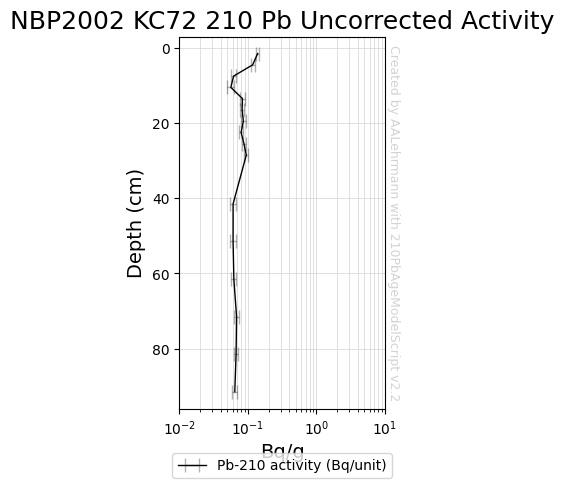

In [33]:
plt.figure(figsize=(3, 5))
plt.errorbar(
    data['Pb-210 activity (Bq/g)'], data['Center point of interval'], 
    xerr=data['Pb-210 activity Uncertainty (Bq-g)'], fmt='-', color=excess_pb210_color, 
    label='Pb-210 activity (Bq/unit)', capsize=5, linewidth=1, 
    ecolor=excess_pb210_error_color
)
plt.xscale('log')
plt.xlim(0.01, 10)
# Highlight intervals with missing radioisotopes using brown spans
for y in missing_depths:
    plt.axhspan(y - 0.5, y + 0.5, alpha=0.5, color='brown', 
                label='Undetectable radioisotope' if y == missing_depths[0] else None)

plt.title(f"{core_name} 210 Pb Uncorrected Activity", fontsize=18)
plt.xlabel("Bq/g", fontsize=14)
plt.ylabel("Depth (cm)", fontsize=14)
plt.gca().invert_yaxis()  # Show depth from surface (invert y-axis)
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.tight_layout()
fig = plt.gcf()
save_figure(fig, basename="AgeModelPlot", directory=save_location, ext=".pdf", dpi=300)
plt.show()



Figure saved -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModelPlot_NBP2002KC72_20250904.pdf


Notes for AgeModelPlot_NBP2002KC72_20250904.pdf (optional):  


README created -> D:\210Pb_thismachine\NBP2002_KC72_gamma spec data\AgeModelPlot_NBP2002KC72_20250904_README_20250904.txt


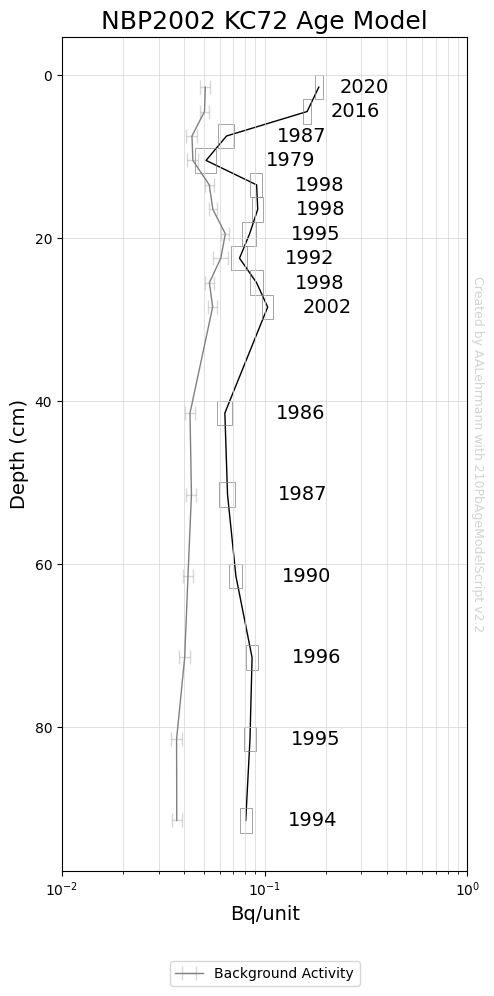

In [34]:
import matplotlib.patches as patches

plt.figure(figsize=(5, 10))

# Calculate vertical errors from top/base to center of interval
depth_errors = np.array([
    [center - top, base - center]
    for top, center, base in zip(
        data['Top of interval (cm)'],
        data['Center point of interval'],
        data['Base of interval (cm)']
    )
]).T  # shape (2, N)

# Calculate symmetric vertical errors
yerr = np.abs(data['Center point of interval'] - data['Top of interval (cm)'])

# Calculate symmetric horizontal errors
xerr = data['Pb-210 activity Uncertainty (Bq-g)']

# Draw connecting line for Excess Pb-210 data points
plt.plot(
    data['Excess Pb-210 (Bq/g)'], data['Center point of interval'],
    color=excess_pb210_color, linewidth=1, zorder=1
)

# Draw error boxes for Excess Pb-210
for i in range(len(data)):
    x = data['Excess Pb-210 (Bq/g)'].iloc[i]
    y = data['Center point of interval'].iloc[i]
    width = xerr.iloc[i] * 2
    height = yerr.iloc[i] * 2
    rect = patches.Rectangle(
        (x - xerr.iloc[i], y - yerr.iloc[i]), width, height,
        linewidth=0.5, edgecolor='grey', facecolor='none'
    )
    plt.gca().add_patch(rect)

# Plot background activity with horizontal error bars only
plt.errorbar(
    data['Averaged supported activity of Bi-214 and Pb-214 (Bq/g)'],
    data['Center point of interval'],
    xerr=data['Background activity uncertainty (Bq/g)'],
    fmt='-', color=supported_activity_color, label='Background Activity',
    capsize=5, linewidth=1, ecolor=supported_activity_error_color
)

# Highlight missing intervals with brown spans
for y in missing_depths:
    plt.axhspan(y - 0.5, y + 0.5, alpha=0.5, color='brown',
                label='Undetectable radioisotope' if y == missing_depths[0] else None)

# Annotate the selected depths with rounded-up calendar years
for i, depth in enumerate(data['Center point of interval']):
    if depth in depths_to_label:
        year_value = data['calendar years pre year of core'].iloc[i]
        if not pd.isna(year_value):
            plt.text(
                data['Excess Pb-210 (Bq/g)'].iloc[i] + 0.05, depth,
                f'{int(np.ceil(year_value))}',
                fontsize=14, color='black', verticalalignment='center'
            )

plt.title(f"{core_name} Age Model", fontsize=18)
plt.xlabel("Bq/unit", fontsize=14)
plt.ylabel("Depth (cm)", fontsize=14)
plt.xscale('log')
plt.xlim(0.01, 1)
plt.gca().invert_yaxis()
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.tight_layout()
fig = plt.gcf()
save_figure(fig, basename="AgeModelPlot", directory=save_location, ext=".pdf", dpi=300)
plt.show()


# Calculate rates

In [ ]:
import pandas as pd
import numpy as np

# Ask user for CSV
csv_file = input("Enter the CSV filename with center point age-depth data (e.g., myfile.csv): ")

# Load the data
age_model = pd.read_csv(csv_file)

# Confirm columns (adjust if needed)
depth_col = "Center point of interval"
age_col = "calendar years pre year of core"

# Sort by depth just in case
age_model = age_model.sort_values(by=depth_col)

# Get lists
depths = age_model[depth_col].values
ages = age_model[age_col].values

# Calculate sedimentation rates between consecutive centerpoints
print("\nSedimentation rates between consecutive center points:")
for i in range(len(depths)-1):
    dz = depths[i+1] - depths[i]
    dt = abs(ages[i+1] - ages[i])
    if dt > 0:
        sed_rate = dz / dt  # cm/year
        print(f"{depths[i]}–{depths[i+1]} cm: {sed_rate:.3f} cm/year")
    else:
        print(f"{depths[i]}–{depths[i+1]} cm: undefined (no time difference)")

# Ask user if they want a custom interval
custom = input("\nWould you like to calculate a sedimentation rate over a custom depth interval? (yes/no): ")
if custom.strip().lower() == "yes":
    custom_range = input("Enter two depths separated by a comma (e.g., 0,11): ")
    custom_depths = [float(d.strip()) for d in custom_range.split(",")]
    if len(custom_depths) != 2:
        print("⚠️ Please enter exactly two depths.")
    else:
        d1, d2 = custom_depths
        # find nearest centerpoints
        closest_d1 = depths[np.argmin(np.abs(depths - d1))]
        closest_d2 = depths[np.argmin(np.abs(depths - d2))]
        age1 = ages[np.argmin(np.abs(depths - d1))]
        age2 = ages[np.argmin(np.abs(depths - d2))]
        dz = closest_d2 - closest_d1
        dt = abs(age2 - age1)
        if dt > 0:
            sed_rate_custom = dz / dt
            print(f"\nCustom interval:")
            print(f"{closest_d1}–{closest_d2} cm: {sed_rate_custom:.3f} cm/year")
        else:
            print("\nCustom interval rate undefined (no time difference).")


# Well done!

#### When you've finished, go to Cell > All Output > Clear to be ready for the next user of this script.